In [1]:
import csv
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
folder_to_name = {'hsbam': 'hsbam',
                  'wtF': 'wtF',
                  'wtJ': 'wtJ',
                  '96h': '96h',
                  'traffic_jam': 'tjdpp',
                  'bam_mutants': 'bam',
                  'oskar': 'osk'
                 }
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/raw data"
data_frames = {}

tech = 'cellranger'

for folder in folder_to_name:
    subfolder = folder_to_name[folder]
    matrix_dir = os.path.join(os.path.join(matrices_dir,subfolder), tech)
    mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx"))
 
    genes_path = os.path.join(matrix_dir, "genes.tsv")
    gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]
 
    barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")
    barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]
    arr=mat.toarray()
    df = pd.DataFrame(arr)
    df.index = gene_names
    df.columns = barcodes 
    data_frames[folder] = df

In [11]:
sample_names_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/smoothed_data"
wtF_samples_name= os.path.join(sample_names_dir, 'wtF.txt')
wtF_samples = pd.read_csv(wtF_samples_name, sep=',', header=None)
wtF_samples = wtF_samples[1]
wtF_samples = [x.split('_')[2] for x in wtF_samples]
wtJ_samples_name= os.path.join(sample_names_dir, 'wtJ.txt')
wtJ_samples = pd.read_csv(wtJ_samples_name, sep=',', header=None)
wtJ_samples = wtJ_samples[1]
wtJ_samples = [x.split('_')[2] for x in wtJ_samples]

In [12]:
wtJ_samples

['AAACCTGAGATACACA',
 'AAAGATGCAGGACGTA',
 'AAAGATGCATCCGTGG',
 'AAAGATGTCTGGTATG',
 'AAAGCAATCTGTCCGT',
 'AAAGTAGAGGACATTA',
 'AAAGTAGCAGGAATCG',
 'AAAGTAGGTAAGTAGT',
 'AAATGCCGTGCGAAAC',
 'AACCATGCATTCTTAC',
 'AACCATGTCAAGGCTT',
 'AACCATGTCAGTCAGT',
 'AACCATGTCTATCGCC',
 'AACCGCGGTTGGGACA',
 'AACGTTGCAGGGATTG',
 'AACTCCCCAGCTGTGC',
 'AACTCCCTCCCGACTT',
 'AACTTTCAGCGATGAC',
 'AACTTTCCAATGAATG',
 'AACTTTCCAGTATGCT',
 'AAGACCTAGACCTAGG',
 'AAGACCTAGCCCTAAT',
 'AAGACCTAGGCCCTTG',
 'AAGACCTAGGCCGAAT',
 'AAGACCTTCGTGACAT',
 'AAGCCGCCACCACCAG',
 'AAGGAGCGTAGCTAAA',
 'AAGGAGCGTTCCATGA',
 'AAGGCAGAGCCGCCTA',
 'AAGGCAGTCACTTACT',
 'AAGGCAGTCATTGCGA',
 'AAGGTTCTCAGCATGT',
 'AAGTCTGCAGTCGTGC',
 'AATCCAGGTCAGAATA',
 'AATCGGTCAAGCTGTT',
 'ACACCAAAGTAAGTAC',
 'ACACCGGTCGCGTAGC',
 'ACACTGAGTGCACCAC',
 'ACAGCCGTCATCTGCC',
 'ACATGGTGTTGAGTTC',
 'ACCAGTAAGCTAACAA',
 'ACCAGTAAGTTGAGTA',
 'ACCGTAAGTATCACCA',
 'ACCTTTACAGTGAGTG',
 'ACCTTTAGTGCAGGTA',
 'ACGAGCCTCCGTCATC',
 'ACGAGGAAGTGGCACA',
 'ACGAGGAGTCC

In [5]:
# from https://github.com/yanailab/knn-smoothing/blob/master/knn_smooth.py
import time
import sys
from math import log, ceil

from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def _freeman_tukey_transform(X):
    """Returns the Freeman-Tukey transformed data."""
    return np.sqrt(X) + np.sqrt(X+1)


def _calculate_pairwise_distances(X, num_jobs=1):
    """Calculates all pairwise distances for X.
    Performs median-normalization and variance stabilization, before
    calculating distances using the Euclidean metric."""
    # median-normalize
    num_transcripts = np.sum(X, axis=0)
    T = (np.median(num_transcripts) / num_transcripts) * X
    # stabilize variance
    F = _freeman_tukey_transform(T)
    # calculate distances
    D = pairwise_distances(F.T, n_jobs=num_jobs, metric='euclidean')
    return D


def knn_smoothing(X, k, num_jobs=1):
    """K-nearest neighbor smoothing.
    Parameters
    ----------
    X : np.ndarray (should of type float/np.float64)
        The UMI count matrix.
    k : int
        The number of nearest neighbors to use for smoothing.
    num_jobs: int
        The number of threads to use. See scikit-learn's
        documentation of the `pairwise_distances` function.
    """
    assert k < X.shape[1], 'Specified k should be smaller than #cells.'
    assert isinstance(X, np.ndarray), 'Input should be a numpy.ndarray.'

    num_powers = int(ceil(log(k+1)/log(2)))
    S = X.copy()

    for p in range(1, num_powers+1):
        k_step = min(pow(2,p)-1, k)
        print('Step %d/%d: Smooth using k=%d'
              % (p, num_powers, k_step)); sys.stdout.flush()

        # determine cell-cell distances based on smoothed matrix
        t0 = time.time()
        D = _calculate_pairwise_distances(S, num_jobs=num_jobs)
        t1 = time.time()
        print('Calculating the pair-wise distances took %.1f s.'
              % (t1-t0)); sys.stdout.flush()

        # sort the distances and generate new smoothed matrix
        t0 = time.time()
        A = np.argsort(D, axis=1, kind='mergesort')
        for j in range(X.shape[1]):
            ind = A[j, :(k_step+1)]
            S[:, j] = np.sum(X[:, ind], axis=1)

        t1 = time.time()
        print('Calculating the smoothed expression matrix took %.1f s.'
              %(t1-t0)); sys.stdout.flush()

    return S



In [13]:
df = data_frames['wtJ']
df.columns = [x.split('-')[0] for x in df.columns]
df = df[wtJ_samples]

In [14]:
df.shape

(17433, 1056)

In [9]:
knn_expr = {}
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for k in k_values:
    knn_expr[k] = knn_smoothing(X=df.values, k=k)
# raw_expr = raw_data_TF_wtJ_20_percent.values[cluster_obj.dendrogram_row.reordered_ind, :][:, cluster_obj.dendrogram_col.reordered_ind]

Step 1/1: Smooth using k=1
Calculating the pair-wise distances took 0.9 s.
Calculating the smoothed expression matrix took 0.7 s.
Step 1/2: Smooth using k=1
Calculating the pair-wise distances took 0.8 s.
Calculating the smoothed expression matrix took 0.6 s.
Step 2/2: Smooth using k=2
Calculating the pair-wise distances took 0.8 s.
Calculating the smoothed expression matrix took 0.8 s.
Step 1/2: Smooth using k=1
Calculating the pair-wise distances took 0.8 s.
Calculating the smoothed expression matrix took 0.7 s.
Step 2/2: Smooth using k=3
Calculating the pair-wise distances took 0.7 s.
Calculating the smoothed expression matrix took 1.0 s.
Step 1/3: Smooth using k=1
Calculating the pair-wise distances took 0.8 s.
Calculating the smoothed expression matrix took 0.7 s.
Step 2/3: Smooth using k=3
Calculating the pair-wise distances took 0.8 s.
Calculating the smoothed expression matrix took 1.0 s.
Step 3/3: Smooth using k=4
Calculating the pair-wise distances took 0.7 s.
Calculating the

In [49]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for k in k_values:
    tmp_df = pd.DataFrame(knn_expr[k], columns=df.columns, index=df.index)
    out_file= os.path.join(sample_names_dir, 'wtJ_{}_smoothed.tsv'.format(k))
    tmp_df.to_csv(out_file, sep='\t')

In [36]:
tmp_df = pd.DataFrame(knn_expr[k], columns=df.columns, index=df.index)
tmp_df.head()

,AAACCTGAGAGGACGG,AAACCTGAGCCTATGT,AAACCTGGTCAAGCGA,AAACCTGTCCGCAGTG,AAAGATGGTATCACCA,AAAGCAAGTAATCACC,AAAGCAATCCTTGGTC,AAAGTAGCAAGCGCTC,AAAGTAGCAGACGCAA,AAAGTAGTCCAAAGTC,...,TTGGAACTCCTTCAAT,TTGGAACTCTGCGACG,TTGTAGGCAGACACTT,TTTACTGAGAAGAAGC,TTTACTGAGGTGCAAC,TTTATGCGTAGAAGGA,TTTCCTCCACGGCCAT,TTTGCGCAGTACGCGA,TTTGCGCCATTAGGCT,TTTGGTTGTCCCTACT
CG11023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l(2)gl,5,13,16,2,4,4,4,1,5,11,...,4,1,6,7,0,14,23,4,3,3
Ir21a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR43609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Cda5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [37]:
df.head()

,AAACCTGAGAGGACGG,AAACCTGAGCCTATGT,AAACCTGGTCAAGCGA,AAACCTGTCCGCAGTG,AAAGATGGTATCACCA,AAAGCAAGTAATCACC,AAAGCAATCCTTGGTC,AAAGTAGCAAGCGCTC,AAAGTAGCAGACGCAA,AAAGTAGTCCAAAGTC,...,TTGGAACTCCTTCAAT,TTGGAACTCTGCGACG,TTGTAGGCAGACACTT,TTTACTGAGAAGAAGC,TTTACTGAGGTGCAAC,TTTATGCGTAGAAGGA,TTTCCTCCACGGCCAT,TTTGCGCAGTACGCGA,TTTGCGCCATTAGGCT,TTTGGTTGTCCCTACT
CG11023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l(2)gl,1,3,1,0,0,0,0,0,2,3,...,0,0,2,2,0,7,15,2,1,1
Ir21a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR43609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Cda5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [51]:
## Look at raw embryo data

In [5]:
embryo_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project/embryo_raw"
filename = os.path.join(embryo_dir, 'dge_raw.txt')
embryo_df = pd.read_csv(filename, sep='\t', index_col=0, header=None)

In [6]:
embryo_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297
0,,,,,,,,,,,,,,,,,,,,,
128up,4,2,0,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,1,0,0
140up,1,3,0,0,0,2,2,3,0,0,...,1,0,1,2,1,1,1,2,0,0
14-3-3epsilon,370,188,115,119,92,120,107,95,84,104,...,33,27,52,97,73,55,27,110,47,45
14-3-3zeta,49,18,16,8,18,13,12,8,21,16,...,2,4,12,15,13,11,5,12,3,8
18w,8,3,1,4,3,1,2,1,0,0,...,1,0,0,0,2,0,0,0,6,2


In [7]:
embryo_df.shape

(8924, 1297)

In [15]:
df.shape

(17433, 1056)

Text(0.5,1,'Histogram showing number of unique molecules per cell: embryo')

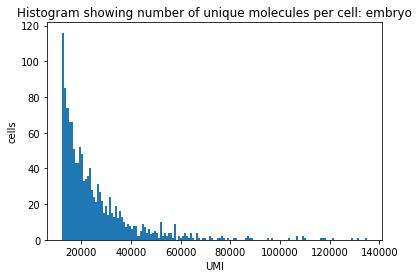

In [33]:
plt.hist(embryo_df.sum(), bins = 150)
plt.ylabel('cells')
plt.xlabel('UMI')
plt.title('Histogram showing number of unique molecules per cell: embryo')

In [26]:
np.median(embryo_df.sum())

20834.0

Text(0.5,1,'Histogram showing number of unique molecules per cell: wtJ filtered')

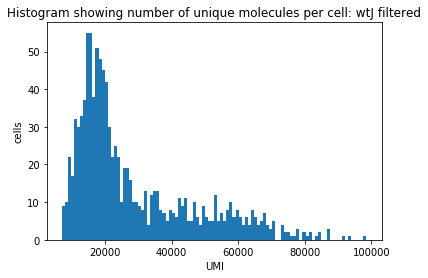

In [34]:
plt.hist(df.sum(), bins = 100)
plt.ylabel('cells')
plt.xlabel('UMI')
plt.title('Histogram showing number of unique molecules per cell: wtJ filtered')

In [27]:
np.median(df.sum())

20909.0

In [40]:
np.median((df > 0).sum(axis = 0))

2937.0

Text(0.5,1,'Histogram showing number of non-zero genes per cell: wtJ filtered')

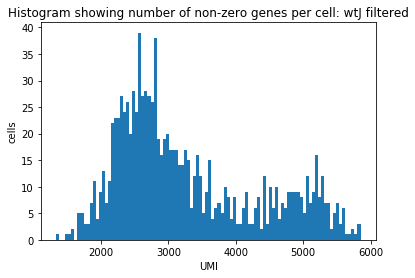

In [36]:
plt.hist((df > 0).sum(axis = 0), bins = 100)
plt.ylabel('cells')
plt.xlabel('UMI')
plt.title('Histogram showing number of non-zero genes per cell: wtJ filtered')

Text(0.5,1,'Histogram showing number of non-zero genes per cell: embryo data')

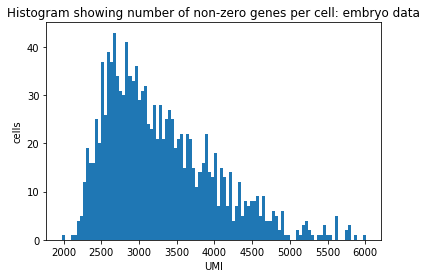

In [37]:
plt.hist((embryo_df > 0).sum(axis = 0), bins = 100)
plt.ylabel('cells')
plt.xlabel('UMI')
plt.title('Histogram showing number of non-zero genes per cell: embryo data')

In [41]:
np.median((embryo_df > 0).sum(axis = 0))

3130.0